<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [0]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

In [3]:
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/cache.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/dataset.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/download.py
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/src/kandinsky.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/images/parrot_cropped1.jpg
import kandinsky

--2019-04-15 16:49:48--  https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/cache.py
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/cache.py [following]
--2019-04-15 16:49:48--  https://raw.githubusercontent.com/Hvass-Labs/TensorFlow-Tutorials/master/cache.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4764 (4.7K) [text/plain]
Saving to: ‘cache.py’

cache.py            100%[===================>]   4.65K  --.-KB/s    in 0s      

2019-04-15 16:49:48 (68.6 MB/s) - ‘cache.py’ saved [4764/4764]

--2019-04-15 16:49:49--  https://gi

In [0]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [0]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [11]:
kandinsky.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [12]:
kandinsky.copy_files()

Creating dataset from the files in: data/kandinsky/
- Data saved to cache-file: data/kandinsky/kandinsky.pkl
- Copied training-set to: data/kandinsky/train/
- Copied test-set to: data/kandinsky/test/


In [0]:
train_dir = kandinsky.train_dir
test_dir = kandinsky.test_dir

In [14]:
model = VGG16(include_top=True, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 7s 0us/step


In [15]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [0]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=0,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=False,
      vertical_flip=False,
      fill_mode='nearest')

In [0]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size = 20
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

In [19]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 6000 images belonging to 3 classes.


In [20]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 450 images belonging to 3 classes.


In [21]:
steps_test = generator_test.n / batch_size
steps_test

22.5

In [0]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [0]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [24]:
class_names = list(generator_train.class_indices.keys())
class_names

['allcolors', 'allshapes', 'yellowleft']

In [25]:
num_classes = generator_train.num_classes
num_classes

3

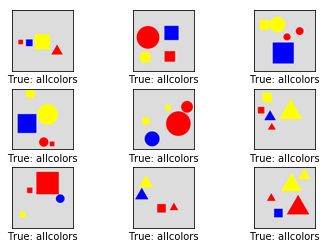

In [26]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [0]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [28]:
!pip install keract

In [0]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))       

In [30]:
import keract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras import backend as K

#session = tf.Session()  
#K.set_session(sess)
#session.run(tf.global_variables_initializer())

def heatmap():  
  img_resized = load_img('parrot_cropped1.jpg', target_size=input_shape)
  
  img_asarr = img_to_array(img_resized)
  img_batch = np.expand_dims(img_asarr, axis=0)
  img_batch = preprocess_input(img_batch)
  
  print(img_batch.shape)
  print(img_batch.dtype) 
  activations = keract.get_activations(new_model, img_batch)
  keract.display_heatmaps(activations, img_asarr)
#heatmap()

Using TensorFlow backend.


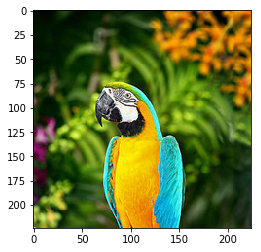

40960/35363 [==================================] - 0s 1us/step
79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [31]:
predict(image_path='parrot_cropped1.jpg')

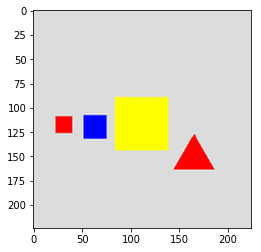

24.16% : envelope
11.86% : web_site
 7.96% : Band_Aid
 2.99% : rubber_eraser
 1.99% : analog_clock


In [32]:
predict(image_path=image_paths_train[0])

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
transfer_layer = model.get_layer('block5_pool')

In [0]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [36]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [48]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
print_layer_trainable()
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False
print_layer_trainable()
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
epochs = 20
steps_per_epoch = 100

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [49]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
300/300 [==============================] - 107s 358ms/step - loss: 0.7904 - categorical_accuracy: 0.6395 - val_loss: 0.7781 - val_categorical_accuracy: 0.5956
Epoch 2/20
300/300 [==============================] - 106s 354ms/step - loss: 0.7268 - categorical_accuracy: 0.6800 - val_loss: 0.7020 - val_categorical_accuracy: 0.6778
Epoch 3/20
300/300 [==============================] - 105s 350ms/step - loss: 0.6781 - categorical_accuracy: 0.7080 - val_loss: 0.6727 - val_categorical_accuracy: 0.7044
Epoch 4/20
300/300 [==============================] - 105s 350ms/step - loss: 0.6446 - categorical_accuracy: 0.7262 - val_loss: 0.6367 - val_categorical_accuracy: 0.7089
Epoch 5/20
300/300 [==============================] - 106s 355ms/step - loss: 0.6004 - categorical_accuracy: 0.7530 - val_loss: 0.6177 - val_categorical_accuracy: 0.7311
Epoch 6/20
300/300 [==============================] - 107s 358ms/step - loss: 0.5702 - categorical_accuracy: 0.7687 - val_loss: 0.5840 - val_categoric

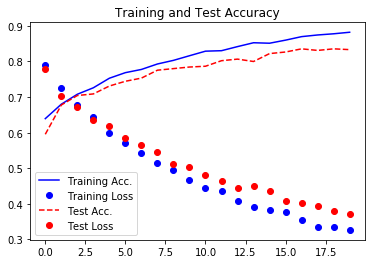

In [50]:
plot_training_history(history)

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [52]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 83.33%


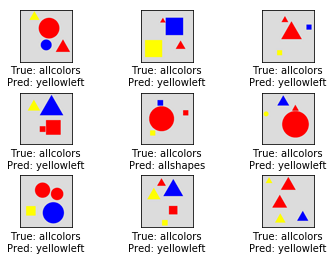

Confusion matrix:
[[122   3  25]
 [  4 143   3]
 [ 37   3 110]]
(0) allcolors
(1) allshapes
(2) yellowleft


In [53]:
example_errors()

In [0]:
## Fine-Tuning

In [0]:
conv_model.trainable = True

In [0]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [0]:
optimizer_fine = Adam(lr=1e-7)
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
300/300 [==============================] - 122s 406ms/step - loss: 0.2992 - categorical_accuracy: 0.8937 - val_loss: 0.3462 - val_categorical_accuracy: 0.8711
Epoch 2/20
300/300 [==============================] - 118s 393ms/step - loss: 0.2730 - categorical_accuracy: 0.9043 - val_loss: 0.3315 - val_categorical_accuracy: 0.8711
Epoch 3/20
300/300 [==============================] - 119s 396ms/step - loss: 0.2643 - categorical_accuracy: 0.9043 - val_loss: 0.3198 - val_categorical_accuracy: 0.8822
Epoch 4/20
300/300 [==============================] - 118s 394ms/step - loss: 0.2518 - categorical_accuracy: 0.9122 - val_loss: 0.3106 - val_categorical_accuracy: 0.8733
Epoch 5/20
300/300 [==============================] - 117s 391ms/step - loss: 0.2444 - categorical_accuracy: 0.9093 - val_loss: 0.3017 - val_categorical_accuracy: 0.8822
Epoch 6/20
300/300 [==============================] - 117s 390ms/step - loss: 0.2347 - categorical_accuracy: 0.9177 - val_loss: 0.2968 - val_categoric

In [0]:
plot_training_history(history)
result = new_model.evaluate_generator(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))
example_errors()